## 1. 정규화 선형회귀

  - **문제 상황**: 모델이 훈련 데이터의 사소한 노이즈까지 모두 학습하여 지나치게 복잡해지는 **과적합(Overfitting)** 현상이 발생할 수 있음.
  - **과적합의 위험**: 과거 데이터는 완벽히 설명하지만, 새로운 데이터에 대해서는 예측 성능이 현저히 떨어져 일반화 능력을 상실함.
  - **해결책**: 정규화 선형회귀(Regularized Linear Regression)는 과적합 문제를 해결하기 위한 기법임.
  - **핵심 원리**: 모델의 계수(가중치)가 불필요하게 커지지 않도록 일종의 '제약' 또는 '페널티'를 부여하여, 모델의 복잡도를 제어하고 일반화 성능을 높임.

## 2. 핵심 원리 파헤치기 (Deep Dive)

  - **정규화 선형회귀**는 기존 선형회귀의 비용 함수(Cost Function)에 모델의 복잡도를 나타내는 '정규화 항(Regularization Term)'을 페널티로 추가함.

  - **핵심 아이디어**: "모델의 복잡도(계수의 크기)도 비용의 일부로 간주하자."

  - **대표적인 3가지 방법**

  1. **Lasso 회귀모형 (L1 정규화)**: 계수들의 **절댓값 합**에 페널티를 부여함.
$$cost=\sum e_{i}^{2}+\alpha\sum|w_{i}|$$
          - **특징**: 중요하지 않은 변수의 계수를 **0으로 만들어** 자동으로 변수 선택(Feature Selection)을 수행하는 효과가 있음.


  2. **Ridge 회귀모형 (L2 정규화)**: 계수들의 **제곱 합**에 페널티를 부여함.
$$cost=\sum e_{i}^{2}+\alpha\sum w_{i}^{2}$$
          - **특징**: 계수들을 0에 가깝게 만들지만 완전히 0으로 만들지는 않음. 모든 변수의 영향력을 전반적으로 줄이는 역할을 함.

  3. **Elastic Net 회귀모형**: Lasso(L1)와 Ridge(L2)의 페널티를 모두 사용하여 두 기법의 장점을 결합한 형태임.
$$cost=\sum e_{i}^{2}+\lambda_{1}\sum|w_{i}|+\lambda_{2}\sum w_{i}^{2}$$

  - **`α` (알파) 또는 `λ` (람다)**: 정규화의 강도를 조절하는 **하이퍼파라미터**. 값이 클수록 더 강한 페널티가 적용되어 계수가 작아짐.

  - **하이퍼파라미터 (Hyperparameter)**: 모델이 스스로 학습하는 변수(가중치 등)가 아닌, 학습 과정에 영향을 주는 분석가가 설정하는 외부 변수(예: 학습률, 정규화 강도 등)를 의미함.

## 3. 실전 코드 분석 및 적용 (Code Walkthrough & Application)

### 3.1 `statsmodels`를 이용한 정규화 회귀


  - `statsmodels`에서는 `OLS` 클래스의 `fit_regularized()` 메서드를 통해 정규화 회귀를 적용함.
  - **statsmodels의 정규화 비용 함수**
  $$0.5\times\frac{RSS}{N}+\alpha\times(0.5\times(1-L1_{wt})\sum w_{i}^{2}+L1_{wt}\sum|w_{i}|)$$
      - `alpha`: 정규화의 전체 강도.
      - `L1_wt`: L1 페널티의 가중치. (1이면 Lasso, 0이면 Ridge, 0과 1 사이면 Elastic Net)

#### 1) 데이터 생성 및 확인

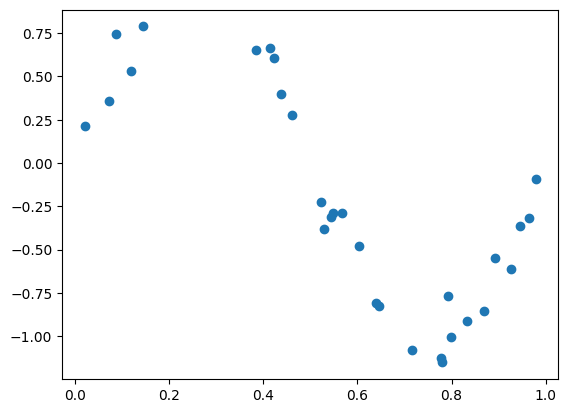

In [1]:
# 필요 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

# jupyter notebook 환경에서 그래프를 바로 보기 위한 설정
%matplotlib inline

# 데이터 생성
n_samples = 30
np.random.seed(0) # 재현 가능성을 위해 시드 고정
X = np.sort(np.random.rand(n_samples)) # 0부터 1 사이의 값 30개 생성
y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1

# 생성된 데이터 시각화
plt.scatter(X, y)
plt.show()

#### 2) 일반 선형회귀 (과적합 이전)


In [2]:
# 데이터프레임 생성
df = pd.DataFrame(np.c_[X, y], columns=["x", "y"])

# 1차 선형회귀 모델 생성 및 학습
model = ols("y ~ x", data=df)
result = model.fit()

# 학습된 모델의 계수 확인
print(result.params)

Intercept    0.713959
x           -1.642204
dtype: float64


##### 코드 해설

##### 시각화

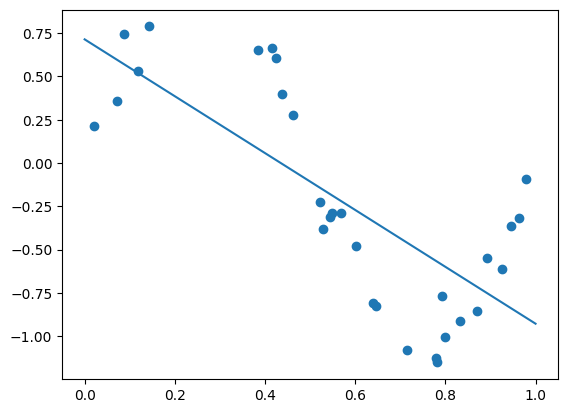

In [3]:
# 회귀선 시각화
plt.scatter(X, y)
xx = np.linspace(0, 1, 1000) # 부드러운 선을 그리기 위한 x축 데이터
plt.plot(xx, result.predict({"x": xx}))
plt.show()

#### 3) 정규화 없는 다항 회귀 (과적합 재현)


  - 9차 다항 회귀모델을 만들어 의도적으로 과적합을 발생시킴.

In [4]:
# 9차 다항 회귀모델 생성 및 학습
# I(xn)은 포뮬러 안에서 x의 n제곱을 변수로 사용하겠다는 의미입니다.
formula = "y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5) + I(x**6) + I(x**7) + I(x**8) + I(x**9)"
model9 = ols(formula, data=df)
result9 = model9.fit()

# 학습된 모델의 계수 확인
print(result9.params)

Intercept       -0.169863
x               25.735773
I(x ** 2)     -428.141683
I(x ** 3)     3866.723114
I(x ** 4)   -18340.939661
I(x ** 5)    49326.072536
I(x ** 6)   -78884.743059
I(x ** 7)    74538.645139
I(x ** 8)   -38453.132184
I(x ** 9)     8350.254984
dtype: float64


##### 코드 해설

##### 시각화

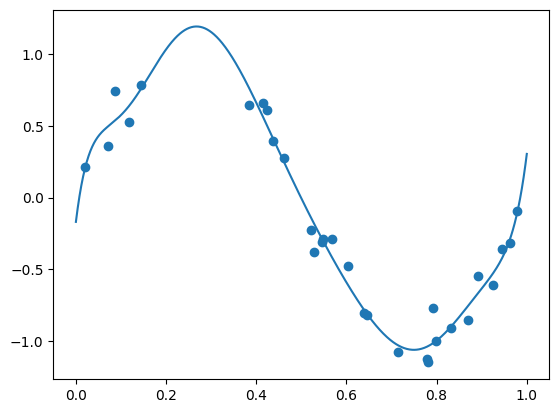

In [5]:
# 과적합된 9차 다항 회귀선 시각화
plt.scatter(X, y)
plt.plot(xx, result9.predict({"x": xx}))
plt.show()

#### 4) Lasso(L1) 회귀모형 적용


In [6]:
# Lasso 회귀모델 학습 (alpha는 정규화 강도)
# model9는 이전 단계에서 정의한 9차 다항식 모델입니다.
result9_lasso = model9.fit_regularized(L1_wt=1, alpha=0.01)

# 학습된 모델의 계수 확인
print(result9_lasso.params)

Intercept    0.687949
x           -1.129134
I(x ** 2)   -1.124878
I(x ** 3)    0.000000
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.000000
I(x ** 8)    0.281484
I(x ** 9)    1.075281
dtype: float64


##### 코드 해설

##### 시각화

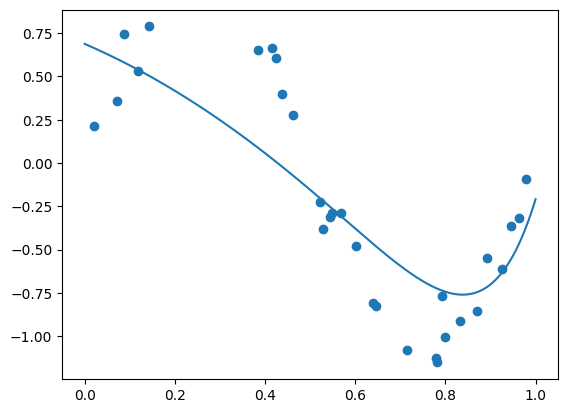

In [7]:
# Lasso 회귀선 시각화
plt.scatter(X, y)
plt.plot(xx, result9_lasso.predict({"x": xx}))
plt.show()

#### 5) Ridge(L2) 회귀모형 적용

In [8]:
# Ridge 회귀모델 학습
result9_ridge = model9.fit_regularized(L1_wt=0, alpha=0.01)

# 학습된 모델의 계수 확인
print(result9_ridge.params)

[ 0.63308745 -0.75705866 -1.07056551 -0.76835135 -0.35530367  0.0121939
  0.29917825  0.50969248  0.65793698  0.75851865]


##### 코드 해설

##### 시각화

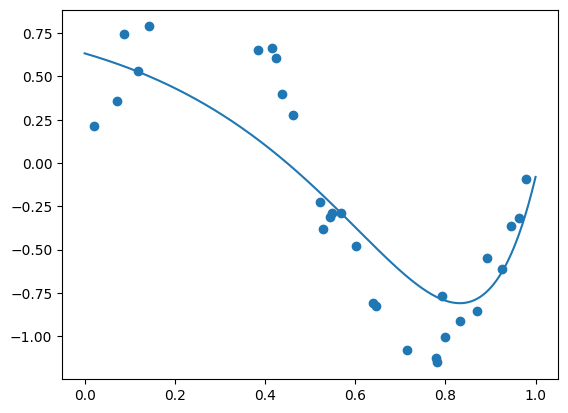

In [9]:
# Ridge 회귀선 시각화
plt.scatter(X, y)
plt.plot(xx, result9_ridge.predict({"x": xx}))
plt.show()

#### 6) Elastic Net 회귀모형 적용


In [10]:
# Elastic Net 회귀모델 학습
result9_elastic = model9.fit_regularized(L1_wt=0.5, alpha=0.01)

# 학습된 모델의 계수 확인
print(result9_elastic.params)

Intercept    0.656203
x           -0.849745
I(x ** 2)   -1.262902
I(x ** 3)   -0.425687
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.304049
I(x ** 8)    0.631908
I(x ** 9)    0.801206
dtype: float64


##### 코드 해설

##### 시각화

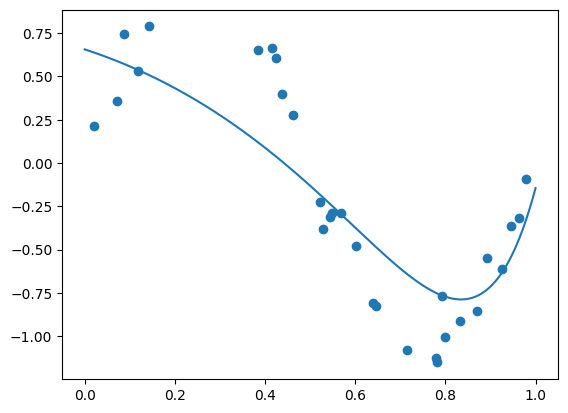

In [11]:
# Elastic Net 회귀선 시각화
plt.scatter(X, y)
plt.plot(xx, result9_elastic.predict({"x": xx}))
plt.show()

### 3.2 `scikit-learn`을 이용한 정규화 회귀

  - `scikit-learn`은 `Lasso`, `Ridge`, `ElasticNet` 클래스를 별도로 제공하며, `PolynomialFeatures`와 `make_pipeline`을 함께 사용하면 코드를 간결하게 구성할 수 있음.


#### 1) 라이브러리 임포트 및 데이터 준비


In [12]:
# 필요 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# 데이터 생성 (이전과 동일)
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
X = X[:, np.newaxis] # scikit-learn 모델에 맞게 2차원 배열로 변경

# 시각화용 함수 정의
def plot_model(model):
    plt.scatter(X, y)
    x_plot = np.linspace(0, 1, 1000)
    plt.plot(x_plot, model.predict(x_plot[:, np.newaxis]))
    plt.show()

#### 2) 정규화 없는 다항 회귀 (과적합 재현)


[ 0.00000000e+00  2.57357731e+01 -4.28141684e+02  3.86672312e+03
 -1.83409397e+04  4.93260726e+04 -7.88847431e+04  7.45386452e+04
 -3.84531322e+04  8.35025499e+03]


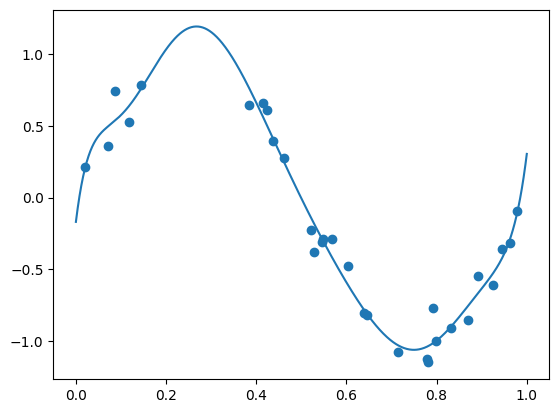

In [13]:
# 9차 다항식 변환기와 선형 회귀모델을 파이프라인으로 연결
poly = PolynomialFeatures(9)
model_lr = make_pipeline(poly, LinearRegression()).fit(X, y)

# 계수 출력 및 시각화
print(model_lr.steps[1][1].coef_)
plot_model(model_lr)

##### 코드 해설

#### 3\) `scikit-learn`을 이용한 정규화 모델 적용

  - `LinearRegression` 부분만 각각 `Lasso`, `Ridge`, `ElasticNet`으로 교체하여 정규화 모델을 간편하게 만들 수 있음.

Laaso 회귀모형

Lasso Coef: [ 0.         -0.07668852 -2.44096313 -0.         -0.          0.
  0.          0.          0.          1.88188725]


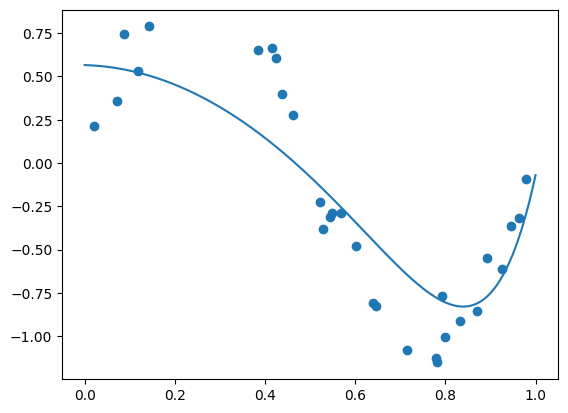

In [14]:
# Lasso 회귀모형
model_lasso = make_pipeline(poly, Lasso(alpha=0.01)).fit(X, y)
print("Lasso Coef:", model_lasso.steps[1][1].coef_)
plot_model(model_lasso)

Ridge 회귀모형

Ridge Coef: [ 0.          1.51430399 -3.90160797 -2.6359859  -0.41526792  1.07530175
  1.64913273  1.52026782  0.94651401  0.13299614]


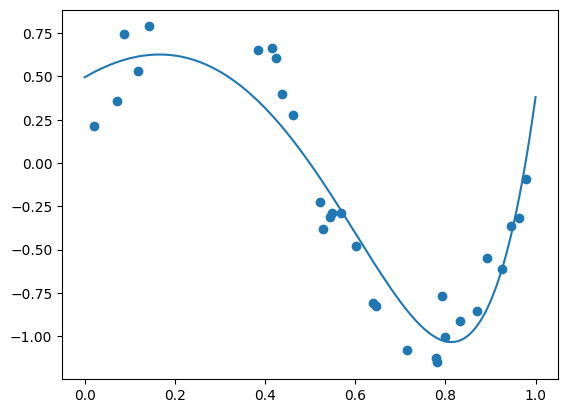

In [15]:
# Ridge 회귀모형
model_ridge = make_pipeline(poly, Ridge(alpha=0.01)).fit(X, y)
print("Ridge Coef:", model_ridge.steps[1][1].coef_)
plot_model(model_ridge)

ElasticNet 회귀모형

ElasticNet Coef: [ 0.         -0.83768018 -1.23944649 -0.50166684 -0.          0.
  0.          0.30382246  0.62459231  0.84262899]


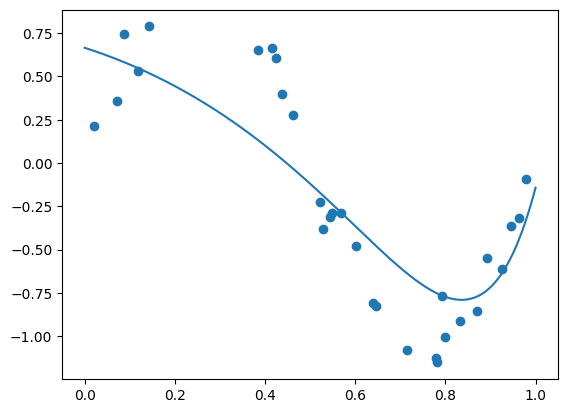

In [16]:
# ElasticNet 회귀모형 (l1_ratio는 L1 페널티의 비중)
model_elastic = make_pipeline(poly, ElasticNet(alpha=0.01, l1_ratio=0.5)).fit(X, y)
print("ElasticNet Coef:", model_elastic.steps[1][1].coef_)
plot_model(model_elastic)

##### 코드 해설

### 3.3 Ridge와 Lasso의 특성 비교

  - 정규화 강도 `alpha` 값의 변화에 따라 각 모델의 계수들이 어떻게 변하는지 시각화하여 두 모델의 차이를 명확히 확인함.

#### 1) 데이터 로드 및 모델 학습


In [17]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso

# 데이터 로드
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# alpha 값의 범위를 로그 스케일로 설정
alpha = np.logspace(-3, 1, 5)

# 각 alpha 값에 대해 Ridge와 Lasso 모델을 학습하고 계수를 저장
data_ridge = []
data_lasso = []

for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(X, y)
    data_ridge.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))

    lasso = Lasso(alpha=a).fit(X, y)
    data_lasso.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))

df_ridge = pd.DataFrame(data_ridge, index=alpha).T
df_lasso = pd.DataFrame(data_lasso, index=alpha).T

print("--- Ridge 계수 ---")
print(df_ridge)
print("\n--- Lasso 계수 ---")
print(df_lasso)

--- Ridge 계수 ---
        0.001       0.010       0.100       1.000       10.000
0   152.133484  152.133484  152.133484  152.133484  152.133484
1    -9.549162   -7.197534    1.308705   29.466112   19.812842
2  -239.086958 -234.549764 -207.192418  -83.154276   -0.918430
3   520.369375  520.588601  489.695171  306.352680   75.416214
4   323.822745  320.517131  301.764058  201.627734   55.025160
5  -712.322159 -380.607135  -83.466034    5.909614   19.924621
6   413.379125  150.484671  -70.826832  -29.515495   13.948715
7    65.811323  -78.589275 -188.678898 -152.040280  -47.553816
8   167.513007  130.312521  115.712136  117.311732   48.259433
9   720.939924  592.347959  443.812917  262.944290   70.143948
10   68.123360   71.134844   86.749315  111.878956   44.213892

--- Lasso 계수 ---
        0.001       0.010       0.100       1.000       10.000
0   152.133484  152.133484  152.133484  152.133484  152.133484
1    -8.996177   -1.304662   -0.000000    0.000000    0.000000
2  -238.896328 -228.

##### 코드 해설



#### 2) `alpha` 변화에 따른 계수 변화 시각화



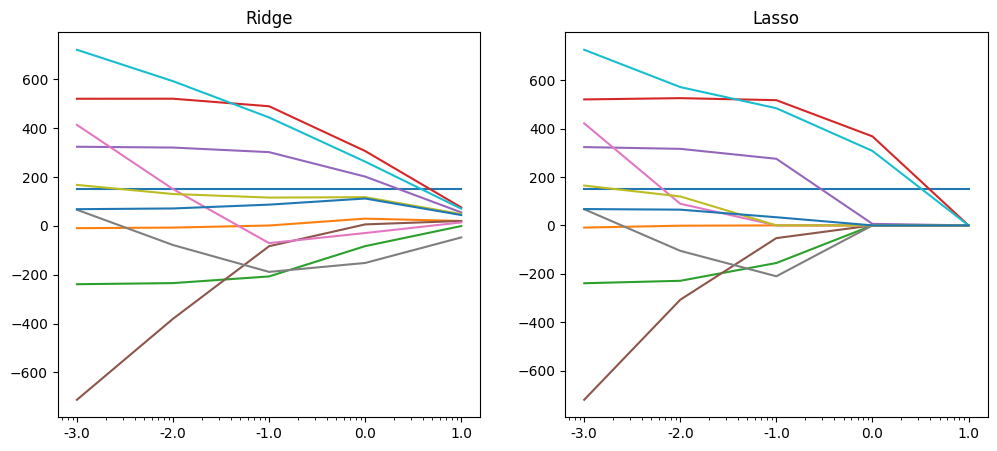

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Ridge 계수 변화
ax1.semilogx(df_ridge.T)
ax1.set_xticks(alpha)
ax1.set_xticklabels(np.log10(alpha).round(1))
ax1.set_title("Ridge")

# Lasso 계수 변화
ax2.semilogx(df_lasso.T)
ax2.set_xticks(alpha)
ax2.set_xticklabels(np.log10(alpha).round(1))
ax2.set_title("Lasso")

plt.show()

##### 코드 해설

## 4. 핵심 요약 (Key Takeaways)


  - **비즈니스 관점**: 정규화는 모델의 **안정성**과 **일반화 성능**을 높여, 새로운 데이터에 대한 **예측 정확도를 향상**시킴.
  - **기술 관점 (과적합 제어)**: **과적합**은 회귀 계수 값을 비정상적으로 크게 만듦. 정규화는 비용 함수에 **계수 크기에 대한 페널티**를 추가하여 모델 복잡도를 제어하고 과적합을 방지함.
  - **기술 관점 (Lasso vs Ridge)**: \*\*Ridge(L2)\*\*는 모든 변수의 영향력을 전반적으로 축소함. 반면, \*\*Lasso(L1)\*\*는 영향력이 적은 변수의 계수를 0으로 만들어 \*\*자동으로 변수를 선택(Feature Selection)\*\*하는 강력한 부가 기능을 제공함.